# Fig 2: LOR displacement distribution

### Import and configuration

In [1]:
from pathlib import Path
import glob
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from sas_pet import photon_shards, intersect_cylinder

In [2]:
MC_DATA_ROOT = Path("../results/MC_data_1e7")
Rs = [5.0, 10.0, 15.0]

R_DET_CM = 15.0
RING_LENGTH_CM = 30.0
Z_MAX_DET_CM = 0.5 * RING_LENGTH_CM

BIN_WIDTH_R = 0.05
BIN_WIDTH_Z = 0.05

RPERP_MAXS = [3.0, 4.0, 5.0]
ZABS_MAXS  = [2.5, 4.0, 4.0]

YLIMS_R = [(0, 42000), (0, 16500), (0, 3200)]
YLIMS_Z = [(0, 90000), (0, 48000), (0, 8750)]

energy_thresholds = np.array([400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510], float)

BINS_R = int(max(RPERP_MAXS) / BIN_WIDTH_R) + 1
BINS_Z = int(max(ZABS_MAXS)  / BIN_WIDTH_Z) + 1

COLUMNWIDTH_PT = 242.5389
INCH_PER_PT = 1 / 72.27
FIG_W = COLUMNWIDTH_PT * INCH_PER_PT
FIG_W_WIDE = FIG_W * 2.25
FIG_H_WIDE = FIG_W * 0.85

FONTSIZE = 10
TICKLABELSIZE = 8

CMAP = plt.cm.inferno
colors = CMAP(np.linspace(0.20, 0.85, len(energy_thresholds)))

In [3]:
mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "font.size": FONTSIZE,
    "axes.labelsize": TICKLABELSIZE,
    "xtick.labelsize": TICKLABELSIZE,
    "ytick.labelsize": TICKLABELSIZE,
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "axes.grid": True,
    "grid.color": "white",
    "axes.axisbelow": True,
    "grid.alpha": 0.9,
    "grid.linewidth": 1.0,
    "axes.facecolor": "whitesmoke",
})

### Accumulate histograms

In [4]:
from sas_pet import DetectorRingConfig, OffsetHistConfig, compute_lor_offset_histograms
det = DetectorRingConfig(R_det_cm=15.0, ring_length_cm=30.0)

hist_cfg = OffsetHistConfig(
    bin_width_r_cm=0.05,
    bin_width_z_cm=0.05,
    rperp_max_by_R={5.0: 3.0, 10.0: 4.0, 15.0: 5.0},
    zabs_max_by_R={5.0: 2.5, 10.0: 4.0, 15.0: 4.0},
)

hist_r_by_R, hist_z_by_R = compute_lor_offset_histograms(
    "../results/MC_data_1e7",
    [5.0, 10.0, 15.0],
    det=det,
    hist=hist_cfg,
    energy_thresholds_keV=energy_thresholds,
)

### $r_\perp$-distribution

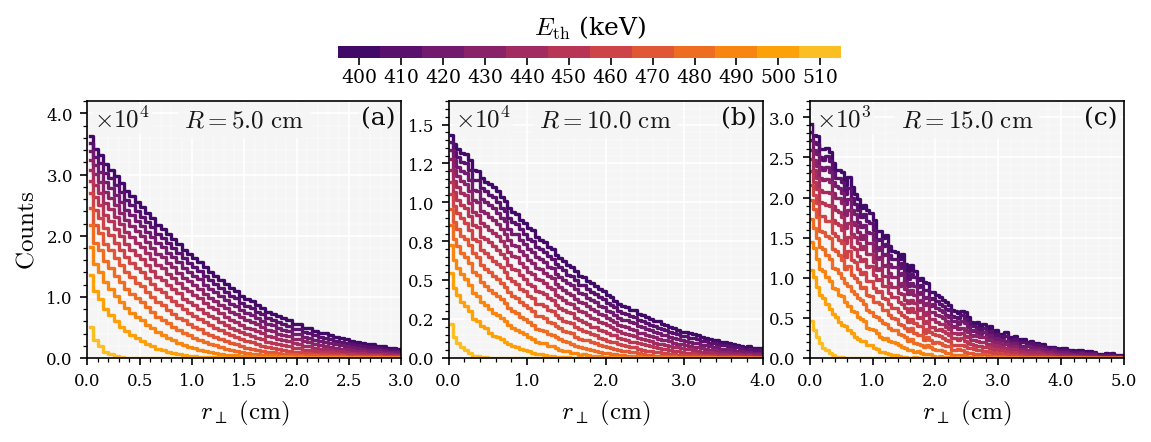

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(FIG_W_WIDE, FIG_H_WIDE), sharey=False)
fig.subplots_adjust(left=0.07, right=0.985, top=0.80, bottom=0.20, wspace=0.15)

centers_r = (np.arange(BINS_R) + 0.5) * BIN_WIDTH_R
panel_tags = ["(a)", "(b)", "(c)"]

for i, (R_obj, rmax) in enumerate(zip(Rs, RPERP_MAXS)):
    ax = axes[i]
    counts_accum = hist_r_by_R[R_obj]

    for Eth, col, counts in zip(energy_thresholds, colors, counts_accum):
        ax.step(centers_r, counts, where="mid", linewidth=1.6, color=col)

    ax.set_ylim(*YLIMS_R[i])
    ax.set_xlim(0.0, rmax)
    ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.1f"))

    if i == 0:
        ax.set_ylabel(r"$\mathrm{Counts}$", fontdict={"size": 12})
    ax.set_xlabel(r"$r_{\perp}~\mathrm{(cm)}$", fontdict={"size": 12})

    sf = mpl.ticker.ScalarFormatter(useMathText=True)
    sf.set_scientific(True)
    sf.set_powerlimits((0, 0))
    ax.yaxis.set_major_formatter(sf)
    fig.canvas.draw()
    oom = ax.yaxis.get_major_formatter().orderOfMagnitude
    ax.yaxis.offsetText.set_visible(False)
    scale = 10.0 ** oom if oom != 0 else 1.0
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, pos, s=scale: f"{(y/s):.1f}"))

    ax.text(0.02, 0.98, rf"$\times 10^{{{oom}}}$", transform=ax.transAxes, ha="left", va="top", fontsize=12, alpha=0.9, bbox=dict(facecolor="whitesmoke", edgecolor="none", alpha=0.75, pad=1.0), zorder=10)

    ax.minorticks_on()
    ax.grid(True, which="major")
    ax.grid(True, which="minor", alpha=0.30, linewidth=0.9)

    ax.text(0.98, 0.98, panel_tags[i], transform=ax.transAxes, ha="right", va="top", fontsize=12, alpha=0.95, bbox=dict(facecolor="whitesmoke", edgecolor="none", alpha=0.75, pad=1.0), zorder=11)
    ax.text(0.5, 0.97, rf"$R = {R_obj:.1f}~\mathrm{{cm}}$", transform=ax.transAxes, va="top", ha="center", fontsize=12, alpha=0.9, bbox=dict(boxstyle="round,pad=0.25", facecolor="whitesmoke", edgecolor="none", alpha=0.85), zorder=11)

N = len(energy_thresholds)
bounds = np.arange(N + 1)
norm = mpl.colors.BoundaryNorm(bounds, ncolors=N)
sm = mpl.cm.ScalarMappable(cmap=mpl.colors.ListedColormap(colors), norm=norm)
sm.set_array([])

pos0 = axes[1].get_position()
pos2 = axes[1].get_position()
cax = fig.add_axes([pos0.x0 * 0.75, pos0.y1 + 0.10, pos2.x1 * 1.25 - pos0.x0, 0.03])

cbar = fig.colorbar(sm, cax=cax, orientation="horizontal", ticks=np.arange(N) + 0.5, drawedges=False)
cbar.ax.set_xticklabels([f"{Eth:.0f}" for Eth in energy_thresholds])
cbar.set_label(r"$E_{\mathrm{th}}$ (keV)", fontsize=12, labelpad=5.0)
cbar.ax.xaxis.set_label_position("top")
cbar.ax.xaxis.set_ticks_position("bottom")
cbar.ax.tick_params(axis="x", labelsize=9, pad=1)
cbar.outline.set_visible(False)
cbar.ax.tick_params(which="minor", bottom=False, top=False)

plt.show()

### Save

In [10]:
out_dir = Path("../results/figures/d_distribution")
r_perp_dir = out_dir / "r_perp_distribution"
out_dir.mkdir(parents=True, exist_ok=True)
r_perp_dir.mkdir(parents=True, exist_ok=True)
fig.savefig(out_dir / "r_perp_distribution" / "r_perp_distribution_all.pdf", bbox_inches="tight", pad_inches=0.02, transparent=False,dpi=300)
fig.savefig(out_dir / "r_perp_distribution" / "r_perp_distribution_all.svg", bbox_inches="tight", pad_inches=0.02, transparent=False,dpi=300)

In [11]:
for i, (R_obj, rmax) in enumerate(zip(Rs, RPERP_MAXS)):

    fig_single, ax = plt.subplots(figsize=(FIG_W, FIG_W * 0.8))

    counts_accum = hist_r_by_R[R_obj]

    for Eth, col, counts in zip(energy_thresholds, colors, counts_accum):
        ax.step(centers_r, counts, where="mid", linewidth=1.6, color=col)

    ax.set_ylim(*YLIMS_R[i])
    ax.set_xlim(0.0, rmax)
    ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.1f"))

    ax.set_ylabel(r"$\mathrm{Counts}$", fontsize=12)
    ax.set_xlabel(r"$r_{\perp}~\mathrm{(cm)}$", fontsize=12)

    sf = mpl.ticker.ScalarFormatter(useMathText=True)
    sf.set_scientific(True)
    sf.set_powerlimits((0, 0))
    ax.yaxis.set_major_formatter(sf)
    fig_single.canvas.draw()
    oom = ax.yaxis.get_major_formatter().orderOfMagnitude
    ax.yaxis.offsetText.set_visible(False)
    scale = 10.0 ** oom if oom != 0 else 1.0
    ax.yaxis.set_major_formatter(
        mpl.ticker.FuncFormatter(lambda y, pos, s=scale: f"{(y/s):.1f}")
    )

    ax.text(
        0.02, 0.98, rf"$\times 10^{{{oom}}}$",
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize=12,
        bbox=dict(facecolor="whitesmoke", edgecolor="none", alpha=0.75, pad=1.0),
    )

    ax.text(
        0.5, 0.97, rf"$R = {R_obj:.1f}~\mathrm{{cm}}$",
        transform=ax.transAxes,
        va="top", ha="center",
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.25", facecolor="whitesmoke", edgecolor="none", alpha=0.85),
    )

    ax.minorticks_on()
    ax.grid(True, which="major")
    ax.grid(True, which="minor", alpha=0.30, linewidth=0.9)

    fig_single.savefig(
        out_dir / "r_perp_distribution" / f"r_perp_distribution_{int(R_obj)}.pdf",
        bbox_inches="tight", pad_inches=0.02, transparent=False, dpi=300,
    )
    fig_single.savefig(
        out_dir / "r_perp_distribution" / f"r_perp_distribution_{int(R_obj)}.svg",
        bbox_inches="tight", pad_inches=0.02, transparent=False, dpi=300,
    )

    plt.close(fig_single)

### $r_\parallel$-distribution

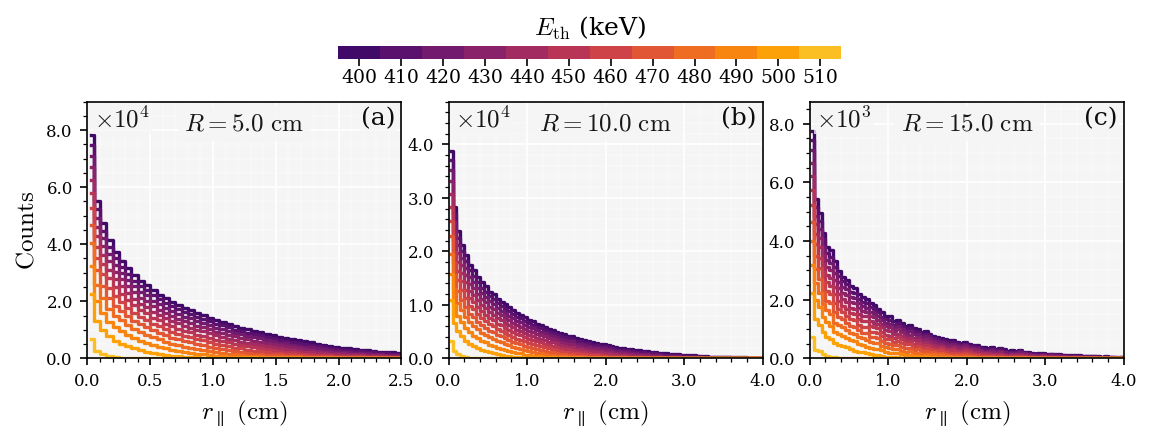

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(FIG_W_WIDE, FIG_H_WIDE), sharey=False)
fig.subplots_adjust(left=0.07, right=0.985, top=0.80, bottom=0.20, wspace=0.15)

centers_z = (np.arange(BINS_Z) + 0.5) * BIN_WIDTH_Z
panel_tags = ["(a)", "(b)", "(c)"]

for i, (R_obj, zmax) in enumerate(zip(Rs, ZABS_MAXS)):
    ax = axes[i]
    counts_accum = hist_z_by_R[R_obj]

    for Eth, col, counts in zip(energy_thresholds, colors, counts_accum):
        ax.step(centers_z, counts, where="mid", linewidth=1.6, color=col)

    ax.set_ylim(*YLIMS_Z[i])
    ax.set_xlim(0.0, zmax)
    ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.1f"))

    if i == 0:
        ax.set_ylabel(r"$\mathrm{Counts}$", fontdict={"size": 12})
    ax.set_xlabel(r"$r_{\parallel}~\mathrm{(cm)}$", fontdict={"size": 12})

    sf = mpl.ticker.ScalarFormatter(useMathText=True)
    sf.set_scientific(True)
    sf.set_powerlimits((0, 0))
    ax.yaxis.set_major_formatter(sf)
    fig.canvas.draw()
    oom = ax.yaxis.get_major_formatter().orderOfMagnitude
    ax.yaxis.offsetText.set_visible(False)
    scale = 10.0 ** oom if oom != 0 else 1.0
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, pos, s=scale: f"{(y/s):.1f}"))

    ax.text(0.02, 0.98, rf"$\times 10^{{{oom}}}$", transform=ax.transAxes, ha="left", va="top", fontsize=12, alpha=0.9, bbox=dict(facecolor="whitesmoke", edgecolor="none", alpha=0.75, pad=1.0), zorder=10)

    ax.minorticks_on()
    ax.grid(True, which="major")
    ax.grid(True, which="minor", alpha=0.30, linewidth=0.9)

    ax.text(0.98, 0.98, panel_tags[i], transform=ax.transAxes, ha="right", va="top", fontsize=12, alpha=0.95, bbox=dict(facecolor="whitesmoke", edgecolor="none", alpha=0.75, pad=1.0), zorder=11)
    ax.text(0.5, 0.96, rf"$R = {R_obj:.1f}~\mathrm{{cm}}$", transform=ax.transAxes, va="top", ha="center", fontsize=12, alpha=0.9, bbox=dict(boxstyle="round,pad=0.25", facecolor="whitesmoke", edgecolor="none", alpha=0.85), zorder=11)

N = len(energy_thresholds)
bounds = np.arange(N + 1)
norm = mpl.colors.BoundaryNorm(bounds, ncolors=N)
sm = mpl.cm.ScalarMappable(cmap=mpl.colors.ListedColormap(colors), norm=norm)
sm.set_array([])

pos0 = axes[1].get_position()
pos2 = axes[1].get_position()
cax = fig.add_axes([pos0.x0 * 0.75, pos0.y1 + 0.10, pos2.x1 * 1.25 - pos0.x0, 0.03])

cbar = fig.colorbar(sm, cax=cax, orientation="horizontal", ticks=np.arange(N) + 0.5, drawedges=False)
cbar.ax.set_xticklabels([f"{Eth:.0f}" for Eth in energy_thresholds])
cbar.set_label(r"$E_{\mathrm{th}}$ (keV)", fontsize=12, labelpad=5.0)
cbar.ax.xaxis.set_label_position("top")
cbar.ax.xaxis.set_ticks_position("bottom")
cbar.ax.tick_params(axis="x", labelsize=9, pad=1)
cbar.outline.set_visible(False)
cbar.ax.tick_params(which="minor", bottom=False, top=False)

plt.show()

### Save

In [17]:
r_parallel_dir = out_dir / "r_parallel_distribution"
r_parallel_dir.mkdir(parents=True, exist_ok=True)
fig.savefig(out_dir / "r_parallel_distribution" / "r_parallel_distribution_all.pdf", bbox_inches="tight", pad_inches=0.02, transparent=False, dpi=300)
fig.savefig(out_dir / "r_parallel_distribution" / "r_parallel_distribution_all.svg", bbox_inches="tight", pad_inches=0.02, transparent=False, dpi=300)

In [14]:
for i, (R_obj, rmax) in enumerate(zip(Rs, RPERP_MAXS)):

    fig_single, ax = plt.subplots(figsize=(FIG_W, FIG_W * 0.8))

    counts_accum = hist_r_by_R[R_obj]

    for Eth, col, counts in zip(energy_thresholds, colors, counts_accum):
        ax.step(centers_r, counts, where="mid", linewidth=1.6, color=col)

    ax.set_ylim(*YLIMS_R[i])
    ax.set_xlim(0.0, rmax)
    ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.1f"))

    ax.set_ylabel(r"$\mathrm{Counts}$", fontsize=12)
    ax.set_xlabel(r"$r_{\perp}~\mathrm{(cm)}$", fontsize=12)

    sf = mpl.ticker.ScalarFormatter(useMathText=True)
    sf.set_scientific(True)
    sf.set_powerlimits((0, 0))
    ax.yaxis.set_major_formatter(sf)
    fig_single.canvas.draw()
    oom = ax.yaxis.get_major_formatter().orderOfMagnitude
    ax.yaxis.offsetText.set_visible(False)
    scale = 10.0 ** oom if oom != 0 else 1.0
    ax.yaxis.set_major_formatter(
        mpl.ticker.FuncFormatter(lambda y, pos, s=scale: f"{(y/s):.1f}")
    )

    ax.text(
        0.02, 0.98, rf"$\times 10^{{{oom}}}$",
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize=12,
        bbox=dict(facecolor="whitesmoke", edgecolor="none", alpha=0.75, pad=1.0),
    )

    ax.text(
        0.5, 0.97, rf"$R = {R_obj:.1f}~\mathrm{{cm}}$",
        transform=ax.transAxes,
        va="top", ha="center",
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.25", facecolor="whitesmoke", edgecolor="none", alpha=0.85),
    )

    ax.minorticks_on()
    ax.grid(True, which="major")
    ax.grid(True, which="minor", alpha=0.30, linewidth=0.9)

    fig_single.savefig(
        out_dir / "r_parallel_distribution" / f"r_parallel_distribution_{int(R_obj)}.pdf",
        bbox_inches="tight", pad_inches=0.02, transparent=False, dpi=300,
    )
    fig_single.savefig(
        out_dir / "r_parallel_distribution" / f"r_perp_parallel_{int(R_obj)}.svg",
        bbox_inches="tight", pad_inches=0.02, transparent=False, dpi=300,
    )

    plt.close(fig_single)